If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import arviz as az
from emcee import EnsembleSampler
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
import theano.tensor as tt
from tqdm.notebook import tqdm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [4]:
class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def A_chol(self):
        return self._A_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is completely flat, so we set the first row and column of the precision matrix to zero
        Lambda_inv = tt.nlinalg.matrix_inverse(Lambda[1:,1:]) # Bad, wrong, don't do it, but it works
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        L_sub_chol = tt.slinalg.cholesky(Lambda[1:,1:])

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        a = tt.slinalg.solve(AInv, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))
        A = tt.nlinalg.matrix_inverse(AInv) # Bad, wrong, don't do it, but it works
        chol_A = tt.slinalg.cholesky(A)

        self._a = a
        self._A_chol = chol_A

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) - 2*tt.sum(tt.log(tt.diag(chol_A))) + 2*tt.sum(tt.log(tt.diag(L_sub_chol)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = np.random.default_rng()

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + (tt.dot(self.A_chol, rng.normal(size=(nylm, size)))).T

In [68]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=prot, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

dt_in_transit = 0.01
dt_out_transit = prot / 10.0

Ttr_half = 0.1

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

y_true = sp.sample_ylm().eval()[0,:]
y_true[0] = 1.0

T = 10*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true

sigma_flux = 0.005*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [69]:
len(t)

2653

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


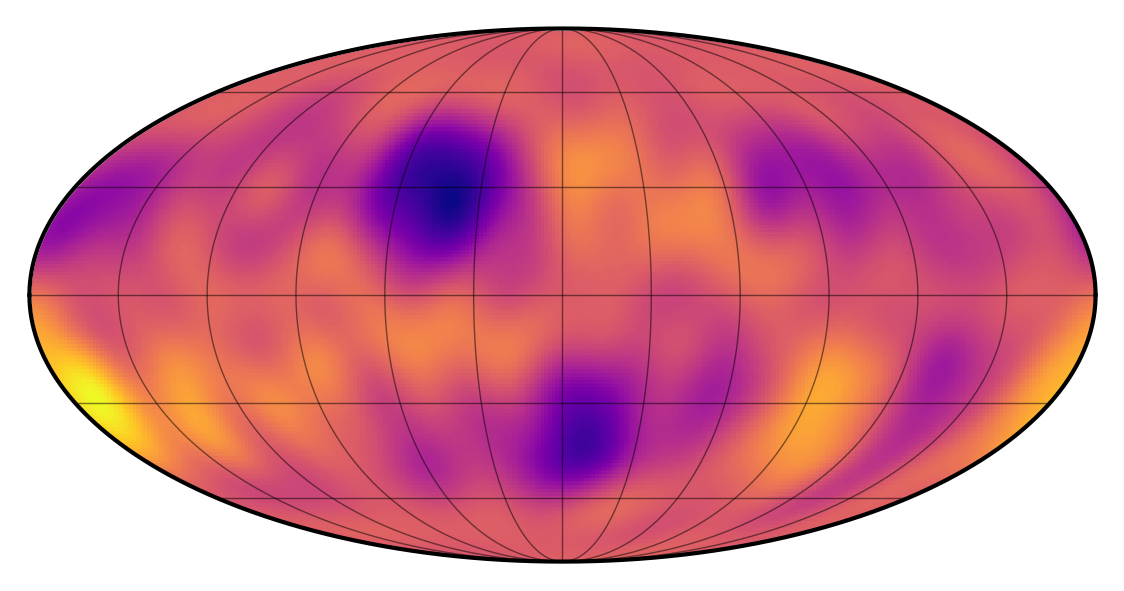

In [70]:
sp.visualize(y_true)

<ErrorbarContainer object of 3 artists>

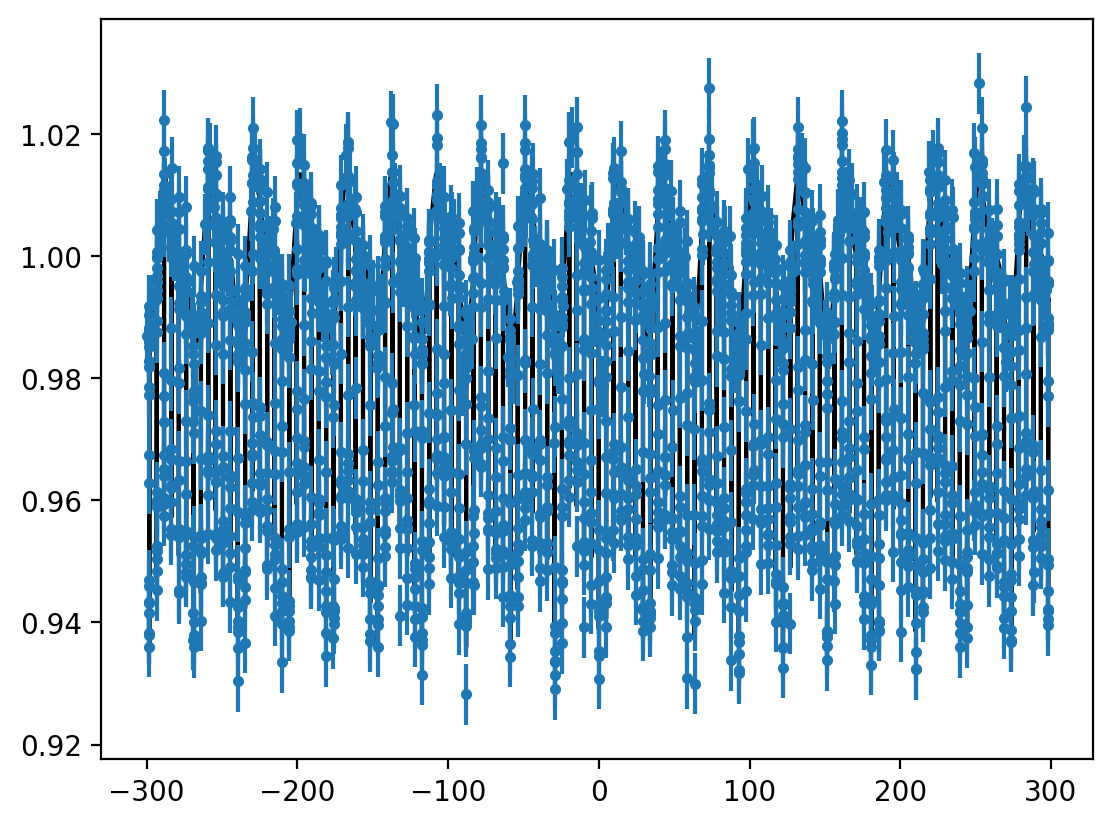

In [71]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

(-0.4887802443, 0.4887802443)

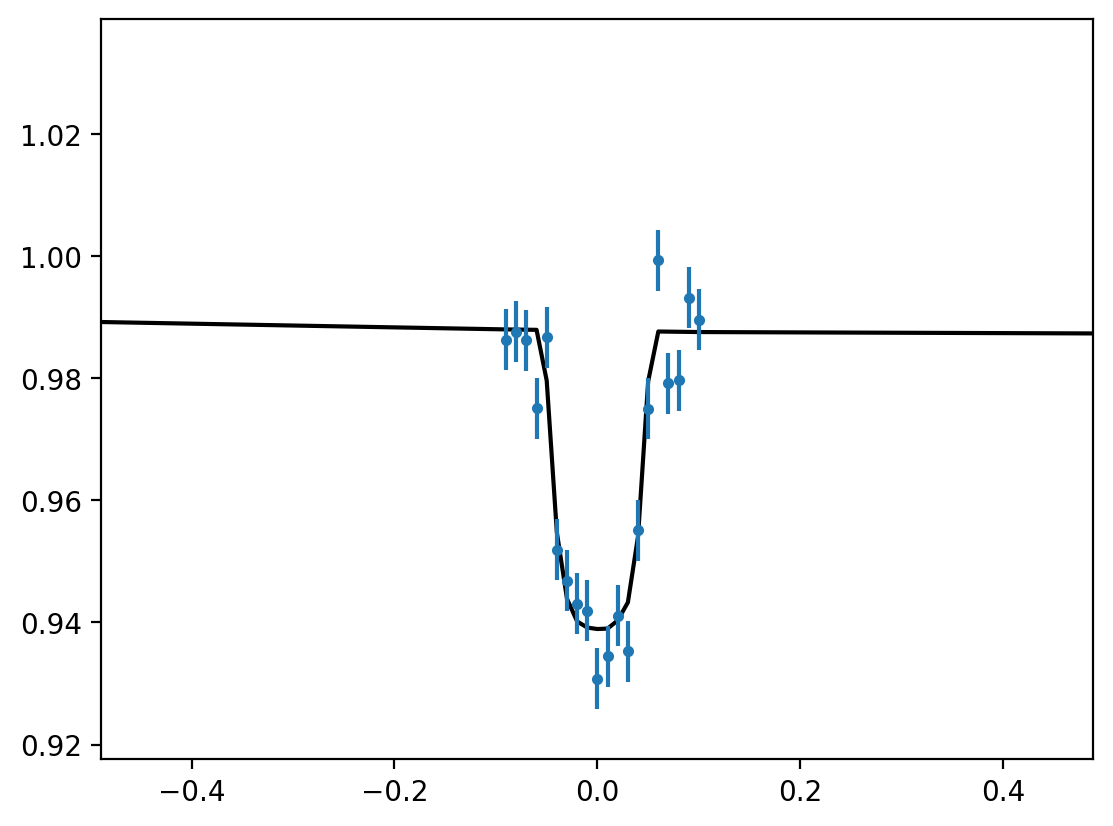

In [72]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)

(-30.0, 30.0)

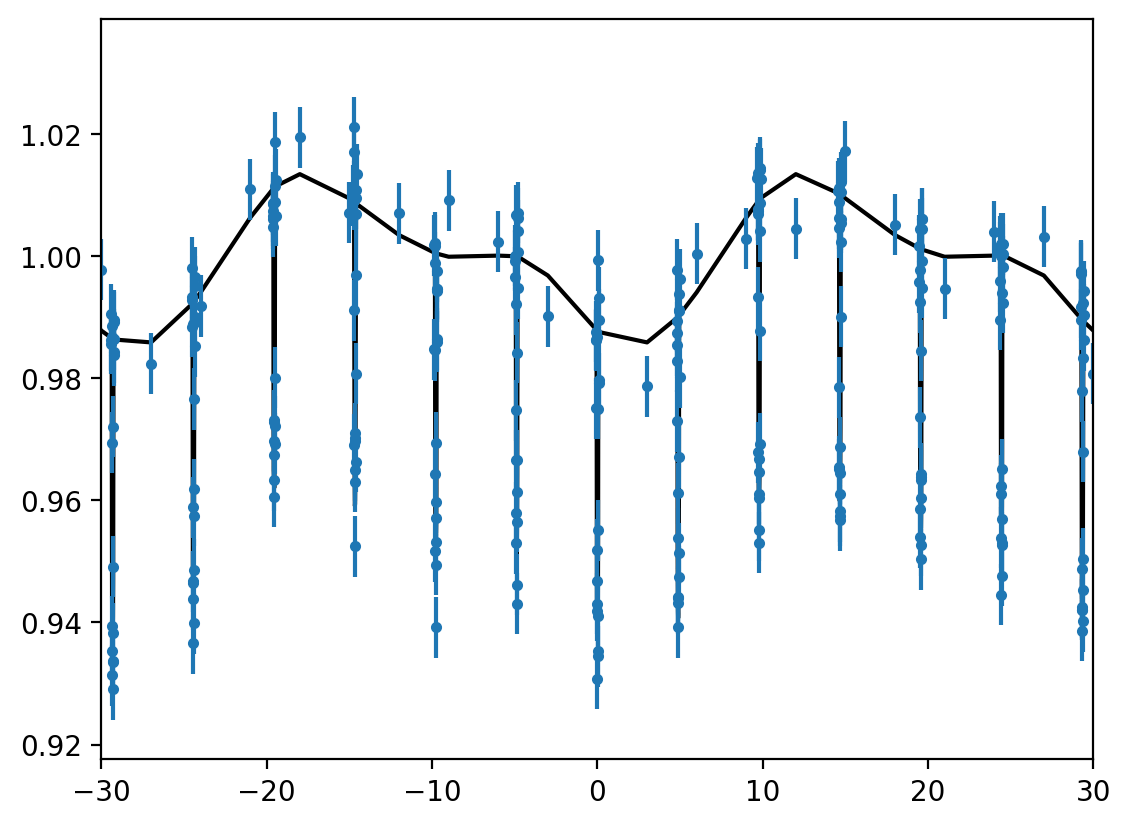

In [73]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')
plt.xlim(-pri.prot.eval(), pri.prot.eval())

In [74]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

(-0.4887802443, 0.4887802443)

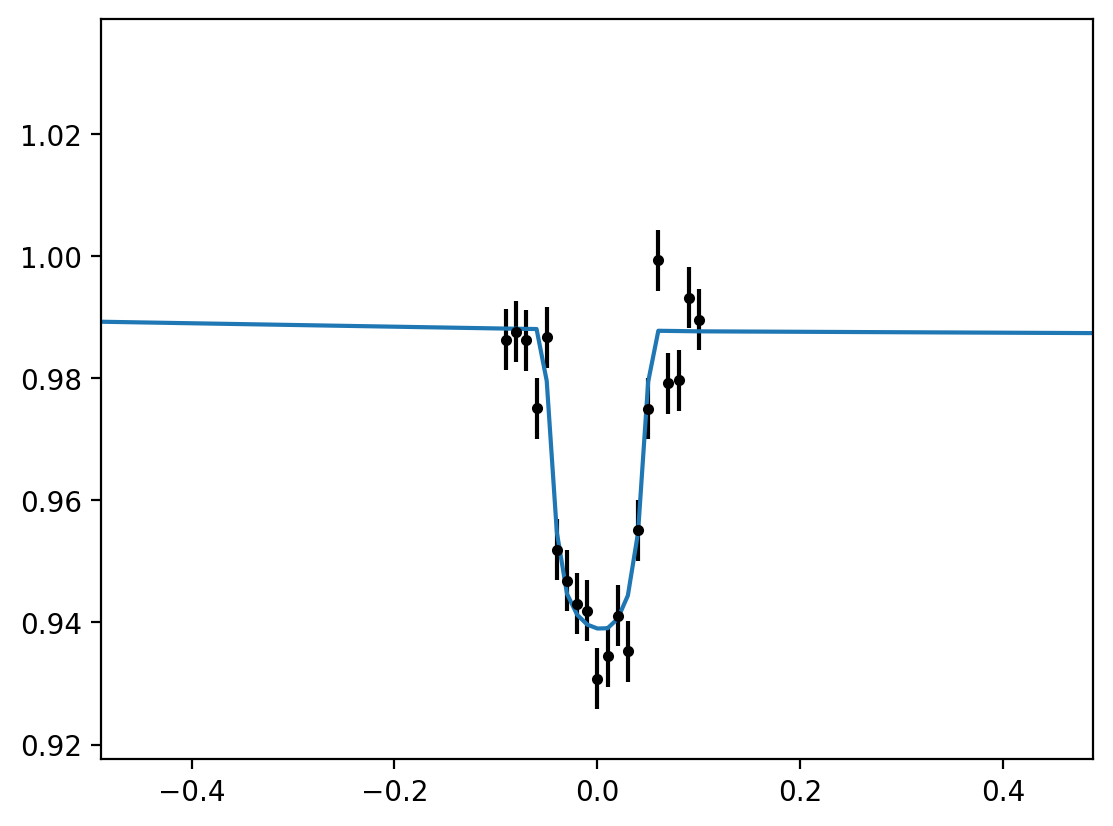

In [75]:
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.', color='k')
plt.plot(t, ssp.design_matrix.eval() @ ssp.a.eval())
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)

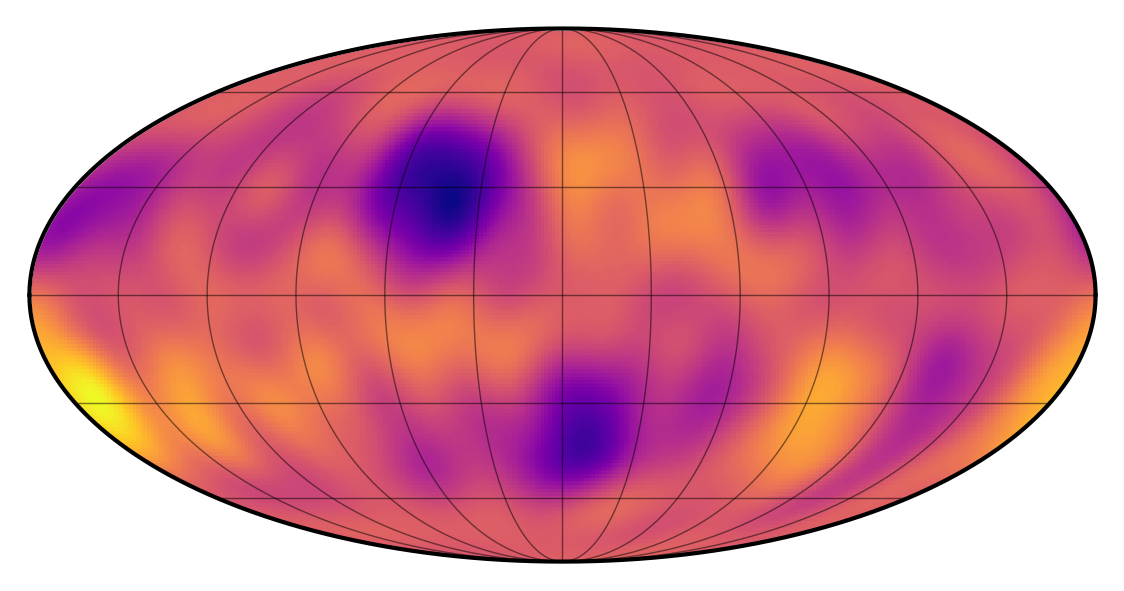

In [76]:
sp.visualize(y_true)

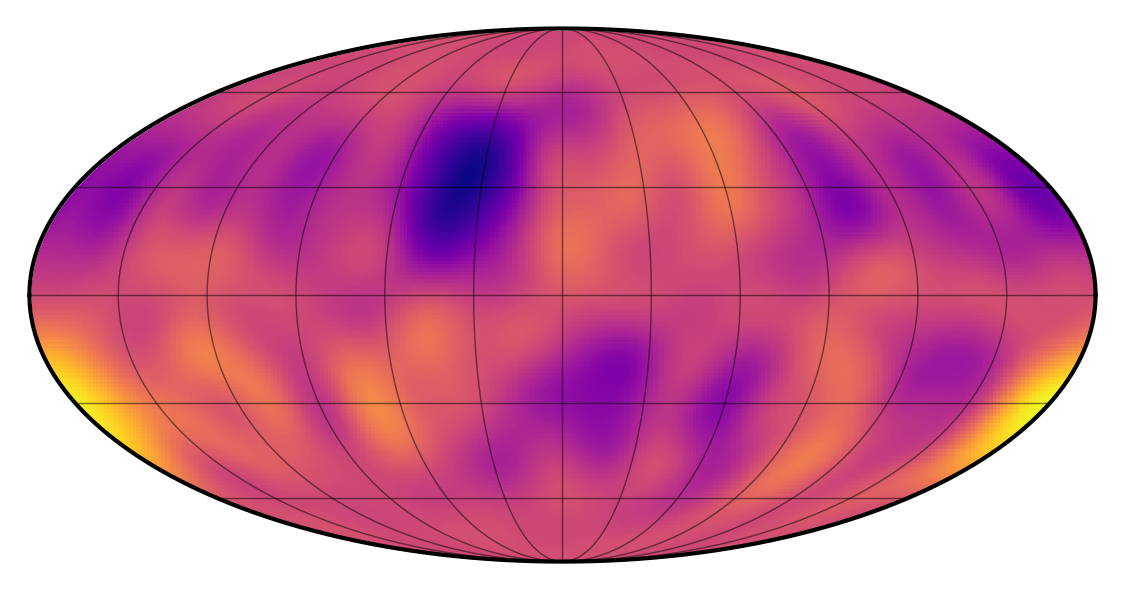

In [77]:
sp.visualize(ylm_draw)

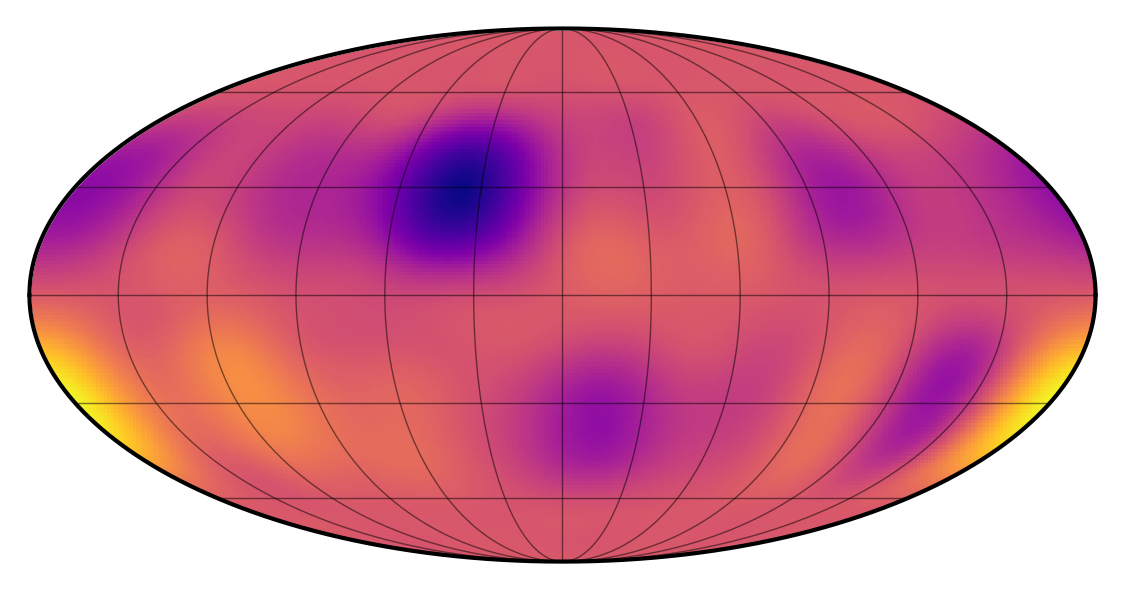

In [78]:
sp.visualize(ssp.a.eval())

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [79]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

11858.636393715029

In [80]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(ylm_draw - ssp.a.eval(), sl.cho_solve((ssp.A_chol.eval(), True), ylm_draw - ssp.a.eval())) - np.sum(np.log(np.diag(ssp.A_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

11858.636393502728

Let's try some fitting: first, we will just try fitting some basic properties of the system.  We will assume that the planetary orbital period is fixed (this can be measured very, very accurately), and we will fit for: 
1. The star rotational period.
2. The planetary radius.
3. The longitude of the ascending node.

At this point, we are assuming (unreasonably---I think we will eventually want to fit these parameters):
1. We know the longitude of the ascending node ($\Omega$)
2. The planet's inclination is 0.
2. The orbital inclination is 0.
3. The planet's eccentricity is 0.
4. We know the mean latitude of spots and the width of the spot band ($\mu$ and $\sigma$).  These will not be measured well (we only have one or two spots to observe, so we don't get good constraints on their distribution), but we should probably let them vary.

Remember: for each draw of the above parameters, we can draw maps using the `sample_ylm_conditional` (we will do this after obtaining the MCMC trace).

In [81]:
with pm.Model() as model:
    log_prot = pm.Uniform('log_prot', np.log(pri.prot.eval()/2), np.log(2*pri.prot.eval()))
    prot = pm.Deterministic('prot', tt.exp(log_prot))

    log_rp = pm.Uniform('log_rp', np.log(sec.r.eval()/2), np.log(2*sec.r.eval()))
    rp = pm.Deterministic('rp', tt.exp(log_rp))

    stellar_cos_inc = pm.Uniform('stellar_cos_inc', -1.0, 1.0, testval=0.0)
    stellar_inc = pm.Deterministic('stellar_inc', 180.0/np.pi*tt.arccos(stellar_cos_inc))

    # For some reason, the model errors out if I try to use Omega as a variable
    # on the planetary transit, but it's happy to have a stellar obliquity.
    # Since only the *relative* angle between transit and star is observable
    # anyway, this is the only relevant degree of freedom.  (Visualize: rotate
    # the star-planet system in the sky until the planet's orbit is "horizontal"
    # (zero obliquity).  The lightcurve is still the same.)  So the preferred
    # value of the stellar obliquity will be -Omega from above, and we pass
    # Omega = 0 to the planet below.
    stellar_obl_x = pm.Normal('stellar_obl_x', mu=0.0, sigma=1.0, testval=np.cos(-30*np.pi/180))
    stellar_obl_y = pm.Normal('stellar_obl_y', mu=0.0, sigma=1.0, testval=np.sin(-30*np.pi/180))
    stellar_obl = pm.Deterministic('stellar_obl', 180.0/np.pi*tt.arctan2(stellar_obl_y, stellar_obl_x))

    pri_model = Primary(starry.Map(ydeg=ydeg, udeg=udeg, inc=stellar_inc, obl=0), r=float(pri.r.eval()), m=float(pri.m.eval()), prot=prot, t0=0.0)
    pri_model.map[1] = u1
    pri_model.map[2] = u2

    sec_model = Secondary(starry.Map(0,0), 
                          t0=0, r=rp, m=float(sec.m.eval()), prot=float(sec.prot.eval()),
                          porb=float(sec.porb.eval()), ecc=float(sec.ecc), Omega=0)
    
    sys_model = System(pri_model, sec_model)

    sp_model = StarryProcess(n=n, 
                             mu=tt.as_tensor_variable(mu, 'mu'),
                             sigma=tt.as_tensor_variable(sigma, 'sigma'),
                             r=tt.as_tensor_variable(r, 'r'),
                             dr=tt.as_tensor_variable(dr, 'dr'),
                             ydeg=ydeg, udeg=udeg, 
                             marginalize_over_inclination=False,)

    # Normally we would make another StarryProcess here, but because none of its parameters are being set in the model for now, we can just reuse `sp`
    ssp_model = StarryStarryProcess(sys_model, sp_model, nt, len(pri.map.y.eval()))

    pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux_obs, sigma_flux))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


Note: the below will error-out if you include the `obl_x` and `obl_y` variables above.  The reason is: the MAP values of those are both zero, approaching the origin with an angle that is the MAP value of `obl`.  But this generates a `0/0` loss of precision.  This isn't a problem for *sampling* because the origin occupies a set of zero volume---so ("almost surely all of") the samples live far from the origin clustered around the right angle.

In [82]:
with model:
    map_soln = pmx.optimize(maxeval=500)

optimizing logp for variables: [stellar_obl_y, stellar_obl_x, stellar_cos_inc, log_rp, log_prot]


message: Desired error not necessarily achieved due to precision loss.
logp: 10292.001204654453 -> 10293.376094272387


In [84]:
print(f'MAP prot = {map_soln["prot"]:.2f}, true prot = {pri.prot.eval():.2f}')
print(f'MAP rp = {map_soln["rp"]:.5f}, true rp = {sec.r.eval():.5f}')
print(f'MAP cos_stellar_inc = {map_soln["stellar_cos_inc"]:.2f}, true cos_stellar_inc = 0.0')
print(f'MAP stellar_obl = {map_soln["stellar_obl"]:.2f}, true stellar_obl = 0.0')

MAP prot = 30.00, true prot = 30.00
MAP rp = 0.13617, true rp = 0.13660
MAP cos_stellar_inc = 0.00, true cos_stellar_inc = 0.0
MAP stellar_obl = 150.00, true stellar_obl = 0.0


In [85]:
ndraw = 100
with model:
    trace = pm.sample(ndraw, tune=ndraw, chains=1, return_inferencedata=False, compute_convergence_checks=False, init='adapt_full')

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (1 chains in 1 job)
NUTS: [stellar_obl_y, stellar_obl_x, stellar_cos_inc, log_rp, log_prot]


This is my version of creating inference data (dealing with some issue in my `arviz` that doesn't know how to process pymc3):

In [62]:
coords = {'chain': trace.chains, 'draw': np.arange(ndraw)}

data = {}
dims = {}
for k in trace.varnames:
    if trace.nchains == 1:
        data[k] = np.reshape(trace[k], (1,) + trace[k].shape)
    shape = data[k].shape

    dims[k] = ['chain', 'draw']
    if len(shape) > 2:
        for kk in range(len(shape) - 2):
            coord_key = f'{k}_dim_{kk}'
            dims[k] = dims[k] + coord_key
            coords[coord_key] = np.arange(shape[kk + 2])

idata = az.from_dict(data, coords=coords, dims=dims)
    

array([[<Axes: title={'center': 'prot'}>,
        <Axes: title={'center': 'prot'}>],
       [<Axes: title={'center': 'rp'}>, <Axes: title={'center': 'rp'}>],
       [<Axes: title={'center': 'stellar_cos_inc'}>,
        <Axes: title={'center': 'stellar_cos_inc'}>],
       [<Axes: title={'center': 'stellar_obl'}>,
        <Axes: title={'center': 'stellar_obl'}>]], dtype=object)

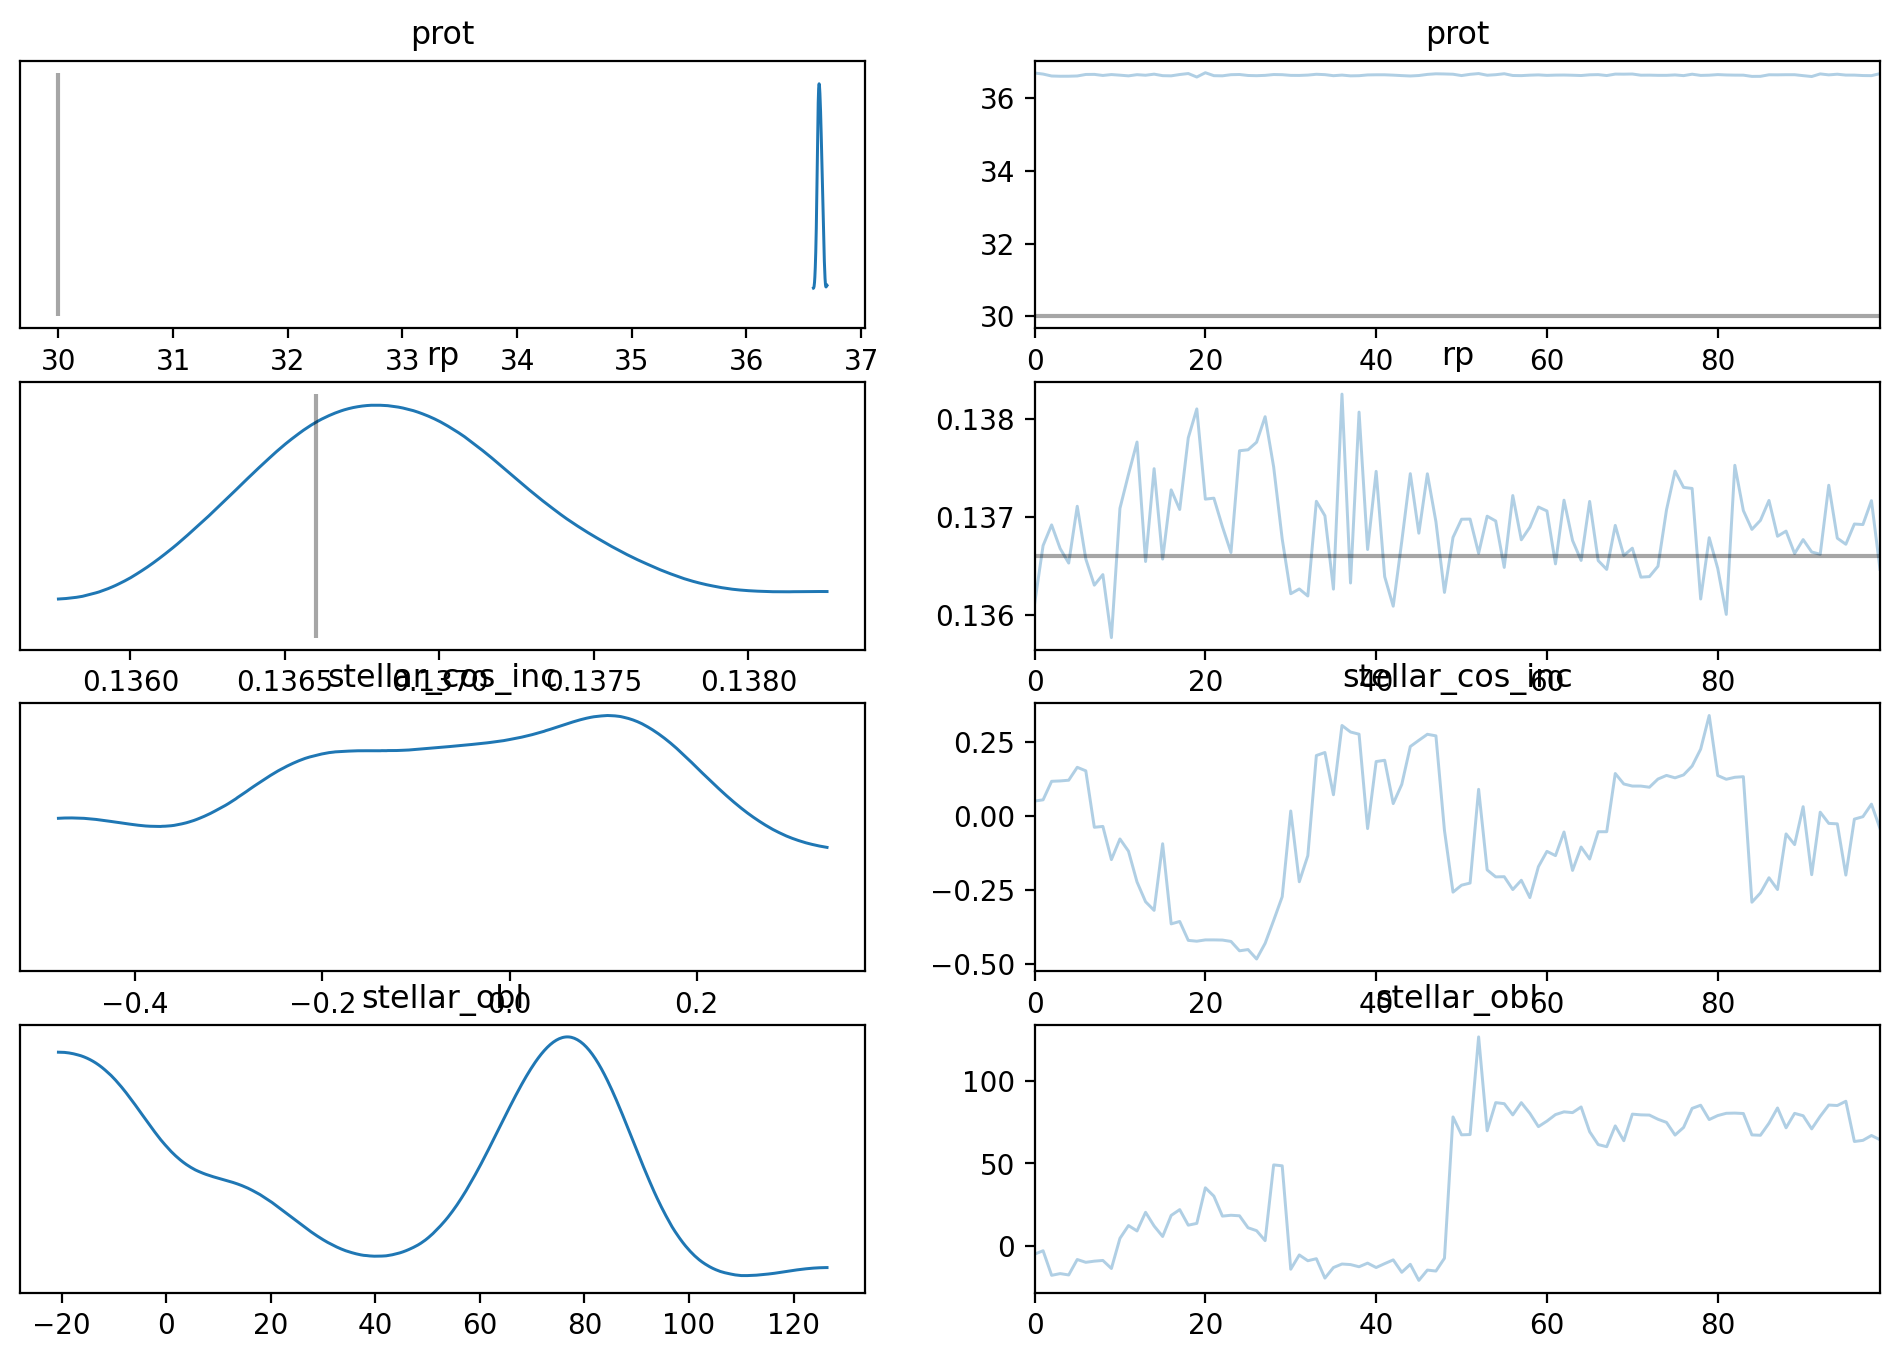

In [64]:
az.plot_trace(idata, var_names=['prot', 'rp', 'stellar_cos_inc', 'stellar_obl'],
              lines=[('prot', {}, pri.prot.eval()), 
                     ('rp', {}, sec.r.eval())])